Globally averaged temperature:

$$
\frac{dT}{dt} = R_i(T) -  R_0(T, C)
$$


$$
R_i(T) = \frac{Q_0}{c} (1 - p \alpha_\text{land} - p \alpha_\text{oc}(T)) 
$$

$$
R_o(T) = \frac{1}{c} (\kappa (T - T_\kappa) - a \ln (\frac{C}{C_0}) )
$$


Accumulated anthropogenic carbon, $S_a$
$$
\frac{d S_a}{dt} = C_a
$$

Atmospheric carbon concentration:

$$
\frac{dC}{dt} = v + C_a - W_a A_v C g^{vege}(T) + \frac{c_0}{\tau_c} \kappa_P (1 - f(T)) + \frac{c_0}{\tau_c} \kappa_B(S_a) (1 - f(T)) - \frac{\lambda}{\tau_c} C(1 - f(T))
$$

Temperature anomaly:
$$
\tilde{T} = T - T_{preindustrial}
$$



$$
\begin{align}
\delta \phi(\tilde{T}, C, S_a) =& \max_{C_a} \eta \log C_a  \\
& + \frac{d \phi (\tilde{T}, C, S_a)}{d\tilde{T}} \left( R_i(T) - R_0(T, C) \right)\\
& + \frac{d\phi(\tilde{T}, C, S_a)}{d C} \left( v + C_a - W_a A_v C g^{vege}(T) + \frac{c_0}{\tau_c} \kappa_P (1 - f(T)) + \frac{c_0}{\tau_c} \kappa_B(S_a) (1 - f(T)) - \frac{\lambda}{\tau_c} C(1 - f(T))\right)\\
& + \frac{d \phi (\tilde{T}, C, S_a)}{d S_a} C_a \\
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 \tilde{T}) (R_i(T) - R_0(T, C))
\end{align}
$$

$$
C_a^{*} = - \frac{ \eta}{\frac{d \phi (\tilde{T}, C, S_a)}{d C} + \frac{d \phi (\tilde{T}, C, S_a)}{d S_a} }
$$

In [1]:
import sys
sys.path.append("../src/")
import numpy as np
import pandas as pd
import pickle
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import SymLogNorm
import matplotlib.mlab
import scipy.io as sio
import pandas as pd
import scipy.optimize as optim
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy import fft, arange, signal
from scipy.interpolate import RegularGridInterpolator
import SolveLinSys
from supportfunctions import finiteDiff
rcParams["figure.figsize"] = (8,5)
rcParams["savefig.bbox"] = 'tight'
                                                                                
def PDESolver(stateSpace, A, B1, B2, B3, C1, C2, C3, D, v0, 
              ε = 1, tol = -10):                                              
                                                                                 

    A = A.reshape(-1,1,order = 'F')                                         
    B = np.hstack([B1.reshape(-1,1,order = 'F'),B2.reshape(-1,1,order = 'F'),B3.reshape(-1,1,order='F')])
    C = np.hstack([C1.reshape(-1,1,order = 'F'),C2.reshape(-1,1,order = 'F'),C3.reshape(-1,1,order='F')])
    D = D.reshape(-1,1,order = 'F')                                         
    v0 = v0.reshape(-1,1,order = 'F')                                       
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)           

    return out                                                            

In [2]:
# Pre-industrial: 282.87K

sa = 1
Ts = 282.9
Cs = 275.5

Q0 = 342.5
p = 0.3
# outgoing radiation linearized
kappa = 1.74
Tkappa = 154
## CO2 radiative forcing
# Greenhouse effect parameter
B = 5.35

alphaland = 0.28
bP = 0.05
bB = 0.08
cod = 3.035
cearth = 10. # 35 #0.107
tauc = 20.

cearth = 35.
tauc   = 6603.

coc0 =350
## Ocean albedo parameters
Talphaocean_low = 219
Talphaocean_high = 299
alphaocean_max = 0.84
alphaocean_min = 0.255

Cbio_low = 50
Cbio_high = 700

T0 = 298
C0 = 280

## CO2 uptake by vegetation
wa = 0.015
vegcover = 0.4

Thigh = 315
Tlow = 282
Topt1 = 295
Topt2 = 310
acc = 5

## Volcanism
Volcan = 0.028


def alphaocean(T):
    """T, matrix, (nT, nC, nF)"""
    temp = np.zeros(T.shape)
    temp[ T< Talphaocean_low ] = alphaocean_max
    temp[ (T>= Talphaocean_low)&(T< Talphaocean_high)] = alphaocean_max + (alphaocean_min - alphaocean_max) / (Talphaocean_high - Talphaocean_low) * (T[(T>= Talphaocean_low)&(T< Talphaocean_high)] - Talphaocean_low)
    temp[T>= Talphaocean_high] = alphaocean_min

    return temp
    
#Fraction of ocean covered by ice
def fracseaice(T):
    
    temp = np.zeros(T.shape)
    temp[ T< Talphaocean_low ] = 1
    temp[ (T>= Talphaocean_low)&(T< Talphaocean_high)] = 1 - 1 / (Talphaocean_high - Talphaocean_low) * (T[(T>= Talphaocean_low)&(T< Talphaocean_high)] - Talphaocean_low)
    temp[T>= Talphaocean_high] = 0

    return temp
    


def biopump(F):
    """F, accumulated anthrpogenic emission"""
    temp = np.zeros(F.shape)
    
    temp[F < Cbio_low] = 1
    temp[(F >= Cbio_low)&(F < Cbio_high)] = 1 - 1/(Cbio_high - Cbio_low) * (F[(F >= Cbio_low)&(F < Cbio_high)] - Cbio_low)
    temp[F >= Cbio_high] = 0
    return temp


def veggrowth(T):
    
    temp = np.zeros(T.shape)
    
    temp[T < Tlow] = 0
    temp[(T >= Tlow)&(T < Topt1)] = acc / (Topt1 - Tlow) * (T[(T >= Tlow)&(T < Topt1)] - Tlow)
    temp[(T >= Topt1)&(T < Topt2)] = acc
    temp[(T >= Topt2)&(T < Thigh)] = acc / (Topt2 - Thigh) * (T[(T >= Topt2)&(T < Thigh)] - Thigh)
    temp[T > Thigh] = 0
    
    return temp


#Incoming radiation modified by albedo
def Ri(T):
    return 1/cearth * (Q0 * (1 - p * alphaland - (1 - p) * alphaocean(T)))

# Outgoing radiation modified by greenhouse effect
def Ro(T, C):
    return 1/cearth * (kappa * (T - Tkappa) -  B * np.log(C / C0))

#Solubility of atmospheric carbon into the oceans
# carbon pumps
def kappaP(T):
    return np.exp(-bP * (T - T0))

def oceanatmphysflux(T):
    return 1 / tauc * (coc0 * (np.exp(-bP * (T - T0))))

def oceanbioflux(T, F, sa):
    
    if sa == 1:
        
        return 1/tauc * (coc0 * (np.exp(bB * biopump(F) * (T - T0))))
    
    elif sa == 0:
        
        return 1/tauc * (coc0 * (np.exp(bB * (T - T0))))
    
    else:
        return ValueError("Wrong input value: 0 or 1.")

def oceanatmcorrflux(C):
    return 1 / tauc * (- cod * C)

In [3]:
# Economic paramaters
gamma_1 = 1.7675 / 10000.
gamma_2 = 2 * 0.0022
delta   = 0.01
eta     = 0.032

# State variable
# Temperature anomaly, in celsius
T_min  = 0. 
T_max  = 20. # 
hT     = 0.1
T_grid = np.arange(T_min, T_max + hT, hT)

# atmospheric carbon concentration, in gigaton
C_min  = 250
C_max  = 500
hC     = 10
C_grid = np.arange(C_min, C_max + hC, hC)

# F, Sa in the notes, accumulative anthropogenic carbon, in gigaton
F_min = 280. # 10. avaoid 
F_max = 2500. # 2500 x2.13 gm # # on hold -> 4000 / 2.13 ppm
hF = 50.
F_grid = np.arange(F_min, F_max + hF, hF)

# meshgrid
(T_mat, C_mat, F_mat) = np.meshgrid(T_grid, C_grid, F_grid, indexing="ij")
stateSpace = np.hstack([
    T_mat.reshape(-1, 1, order="F"),
    C_mat.reshape(-1, 1, order="F"),
    F_mat.reshape(-1, 1, order="F")
])

T_mat.shape

(201, 26, 46)

In [4]:
To = 282.87 # Mean with no anthropogenic carbon emissions, in Fᵒ

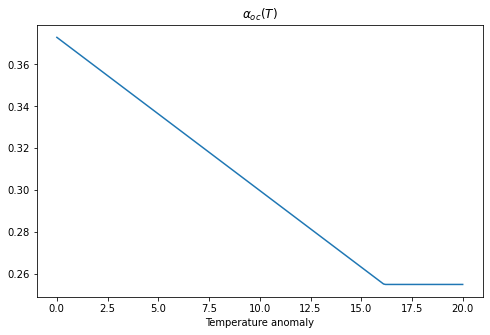

(0.255, 0.372950625)

In [5]:
α_ocean = alphaocean(T_grid + To)
plt.plot(T_grid, α_ocean)
plt.xlabel("Temperature anomaly")
plt.title("$α_{oc}(T)$")
plt.show()
α_ocean.min(), α_ocean.max()

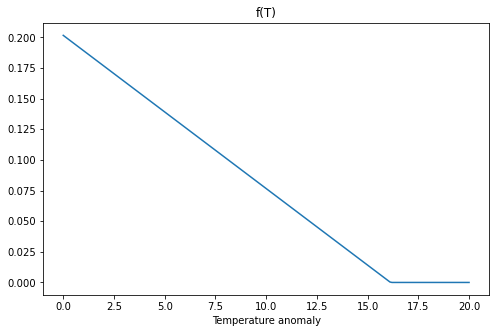

(0.0, 0.20162499999999994)

In [6]:
frac_sea_ice = fracseaice(T_grid + To)
plt.plot(T_grid, frac_sea_ice)
plt.xlabel("Temperature anomaly")
plt.title("f(T)")
plt.show()
frac_sea_ice.min(), frac_sea_ice.max()

In [20]:
frac_sea_ice.mean()

0.08140298507462679

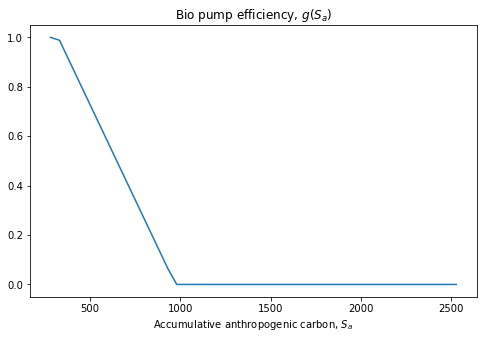

In [19]:
Fo = 272.3 # pre-industrial cumulated emission
bio_pump_efficiency = biopump(F_grid - Fo)
plt.plot(F_grid, bio_pump_efficiency)
plt.xlabel("Accumulative anthropogenic carbon, $S_a$")
plt.title("Bio pump efficiency, $g(S_a)$")
plt.show()

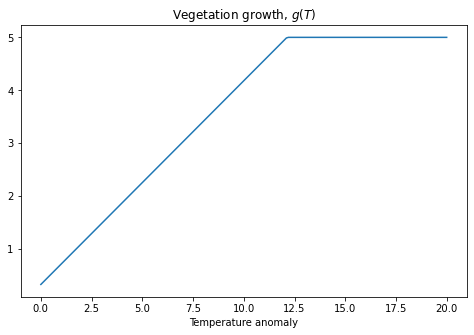

(0.33461538461538637, 5.0)

In [18]:
vege_growth = veggrowth(To + T_grid)


plt.plot(T_grid, vege_growth)
plt.xlabel("Temperature anomaly")
plt.title("Vegetation growth, $g(T)$")
plt.show()

vege_growth.min(), vege_growth.max()

In [17]:
vege_growth.mean()

3.5806352851128977

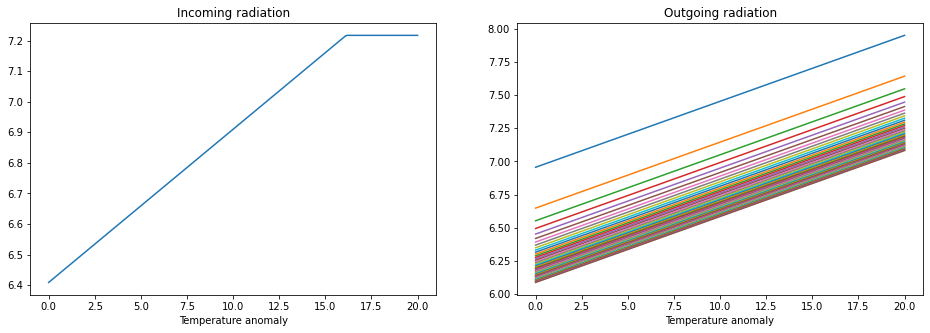

In [16]:
plt.subplots(1,2, figsize=(16, 5))
plt.subplot(121)

plt.title("Incoming radiation")
ri = Ri(To + T_grid)
ro = Ro(To + T_mat[:, 0, :], F_mat[:,0, :] - Fo)
plt.plot(T_grid, ri)
plt.xlabel("Temperature anomaly")

plt.subplot(122)
plt.title("Outgoing radiation")
plt.plot(T_grid, ro)
plt.xlabel("Temperature anomaly")
plt.show()

Text(0.5, 0, 'Temperature anomaly')

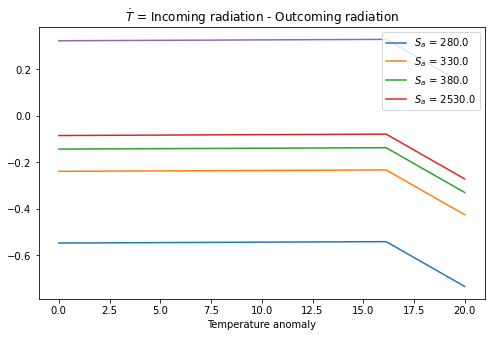

In [15]:
plt.title("$\\dot{T}$ = Incoming radiation - Outcoming radiation")
ri = Ri(To + T_mat[:, 0, :])
ro = Ro(To + T_mat[:, 0, :], F_mat[:,0, :] - Fo)
plt.plot(T_grid, (ri - ro)[:, [0, 1,2,3, -1]])
plt.legend(["$S_a$ = {}".format(F) for F in F_grid[[0, 1, 2,-1]]])
plt.xlabel("Temperature anomaly")

In [14]:
T_grid[5], F_grid[17], C_grid[1]

(0.5, 1130.0, 260)

In [14]:
(ri - ro)[6, 17], 10 * 1.86/1000

(0.17366649657357502, 0.018600000000000002)

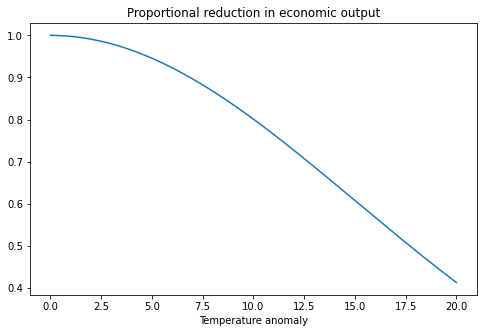

In [21]:
dG  = gamma_1 + gamma_2 * T_grid
G = gamma_1 * T_grid + gamma_2 / 2 * T_grid**2
plt.plot(T_grid, np.exp( -G) )
plt.xlabel("Temperature anomaly")
plt.title("Proportional reduction in economic output")
plt.show()

In [22]:
# Economic paramaters
gamma_1 = 1.7675 / 10000.
gamma_2 = 2 * 0.0022
delta   = 0.01
eta     = 0.032

# State variable
# Temperature anomaly, in celsius
T_min  = 1e-8 
T_max  = 10. # 
hT     = 0.2
T_grid = np.arange(T_min, T_max + hT, hT)

# atmospheric carbon concentration, in gigaton
C_min  = 200.
C_max  = 400.
hC     = 10.
C_grid = np.arange(C_min, C_max + hC, hC)

# F, Sa in the notes, accumulative anthropogenic carbon, in gigaton, since 1800
F_min = 0. # 10. avaoid 
F_max = 300. # 2500 x2.13 gm # # on hold -> 4000 / 2.13 ppm
hF = 10.
F_grid = np.arange(F_min, F_max + hF, hF)

# meshgrid
(T_mat, C_mat, F_mat) = np.meshgrid(T_grid, C_grid, F_grid, indexing="ij")
stateSpace = np.hstack([
    T_mat.reshape(-1, 1, order="F"),
    C_mat.reshape(-1, 1, order="F"),
    F_mat.reshape(-1, 1, order="F")
])

T_mat.shape

(51, 21, 31)

In [27]:

tauc   = 210
cearth = tauc*0.0053+0.0029

v0 =  - eta * T_mat - eta * F_mat
# v0 =  delta * eta * np.log(delta /4 * (9000/2.13 - F_mat)) + (eta - 1) * gamma_2 * T_mat / cearth * (B * np.log(C_mat/ C0) + kappa * (T_mat + To - Tkappa))

dG  = gamma_1 + gamma_2 * T_mat
epsilon  = 0.05
count    = 0
error    = 1.
tol      = 1e-8
max_iter = 5000
fraction = 0.05


while error > tol and count < max_iter:
    
    dvdT  = finiteDiff(v0, 0, 1, hT)
    dvdTT = finiteDiff(v0, 0, 2, hT)
    dvdC  = finiteDiff(v0, 1, 1, hC)
#     dvdC[dvdC >= - 1e-16] = - 1e-16
    dvdCC = finiteDiff(v0, 1, 2, hC)
    dvdF  = finiteDiff(v0, 2, 1, hF)
    dvdFF = finiteDiff(v0, 2, 2, hF)
        

    Ca = - eta * delta / (dvdC + dvdF)

    Ca[Ca <= 1e-32] = 1e-32
    
    if count >=1:
        Ca = Ca * fraction + Ca_star * (1 - fraction)
    
#     Ca = np.ones(T_mat.shape)
    A  = - delta * np.ones(T_mat.shape)
    B1 = Ri(T_mat + To) - Ro(T_mat + To, C_mat)
    B2 = Volcan
    B2 += Ca * sa
    B2 -= wa * C_mat * vegcover * veggrowth(T_mat +To)
    B2 += oceanatmphysflux(T_mat + To)  * (1 - fracseaice(T_mat + To))
    B2 += oceanbioflux(T_mat + To, F_mat, sa) * (1 - fracseaice(T_mat + To))
    B2 += oceanatmcorrflux(C_mat) * (1 - fracseaice(T_mat + To))
    B3 = Ca
    C1 = 0.0 * np.ones(T_mat.shape)
    C2 = 0.0 * np.ones(T_mat.shape)
    C3 = np.zeros(T_mat.shape)
    D  = eta * delta * np.log(Ca) + (eta - 1) * dG * B1

    out = PDESolver(stateSpace, A, B1, B2, B3, C1, C2, C3, D, v0, epsilon)
    v = out[2].reshape(v0.shape, order="F")

    rhs_error = A * v0 + B1 * dvdT + B2 * dvdC + B3 * dvdF + C1 * dvdTT + C2 * dvdCC + C3 * dvdFF + D
    rhs_error = np.max(abs(rhs_error))
    lhs_error = np.max(abs((v - v0)/epsilon))

    error = lhs_error
    v0 = v
    Ca_star = Ca
    count += 1

    print("Iteration: %s;\t False Transient Error: %s;\t PDE Error: %s\t" % (count, lhs_error, rhs_error))

print("Total iteration: %s;\t LHS Error: %s;\t RHS Error %s\t" % (count, lhs_error, rhs_error))

Iteration: 1;	 False Transient Error: 0.20362856022206444;	 PDE Error: 0.2037402520482232	
Iteration: 2;	 False Transient Error: 0.20350814687013496;	 PDE Error: 0.20362855740097524	
Iteration: 3;	 False Transient Error: 0.2033790687892889;	 PDE Error: 0.20350814422727667	
Iteration: 4;	 False Transient Error: 0.2032413801071442;	 PDE Error: 0.20337906643156417	
Iteration: 5;	 False Transient Error: 0.20309513517457134;	 PDE Error: 0.2032413781187914	
Iteration: 6;	 False Transient Error: 0.20294038857830543;	 PDE Error: 0.20309513362094353	
Iteration: 7;	 False Transient Error: 0.20277719514318449;	 PDE Error: 0.2029403875076458	
Iteration: 8;	 False Transient Error: 0.2026056099331086;	 PDE Error: 0.20277719458970944	
Iteration: 9;	 False Transient Error: 0.20242568825029394;	 PDE Error: 0.20260560991886015	
Iteration: 10;	 False Transient Error: 0.20223748563250155;	 PDE Error: 0.20242568878630968	
Iteration: 11;	 False Transient Error: 0.2020410578539611;	 PDE Error: 0.202237486721

Iteration: 91;	 False Transient Error: 0.16500905932979038;	 PDE Error: 0.1656643899203369	
Iteration: 92;	 False Transient Error: 0.1643506787456417;	 PDE Error: 0.16500905512214106	
Iteration: 93;	 False Transient Error: 0.16368932381286783;	 PDE Error: 0.16435067445025	
Iteration: 94;	 False Transient Error: 0.16302506630658797;	 PDE Error: 0.16368931943636386	
Iteration: 95;	 False Transient Error: 0.16235797824574405;	 PDE Error: 0.16302506185597984	
Iteration: 96;	 False Transient Error: 0.16168813189068487;	 PDE Error: 0.16235797372774863	
Iteration: 97;	 False Transient Error: 0.16101559973940027;	 PDE Error: 0.16168812731198226	
Iteration: 98;	 False Transient Error: 0.16034045452208545;	 PDE Error: 0.16101559510674981	
Iteration: 99;	 False Transient Error: 0.159662769193325;	 PDE Error: 0.1603404498423286	
Iteration: 100;	 False Transient Error: 0.15898261692104398;	 PDE Error: 0.1596627644730057	
Iteration: 101;	 False Transient Error: 0.15830007107442867;	 PDE Error: 0.158

Iteration: 182;	 False Transient Error: 0.13345926244220152;	 PDE Error: 0.13521302005995844	
Iteration: 183;	 False Transient Error: 0.13344714194534646;	 PDE Error: 0.1352211862390071	
Iteration: 184;	 False Transient Error: 0.13343145791054667;	 PDE Error: 0.13522805880350036	
Iteration: 185;	 False Transient Error: 0.13341222110923923;	 PDE Error: 0.13523132706794608	
Iteration: 186;	 False Transient Error: 0.13338944265470332;	 PDE Error: 0.13523099933322474	
Iteration: 187;	 False Transient Error: 0.13336313399896937;	 PDE Error: 0.1352270842553086	
Iteration: 188;	 False Transient Error: 0.13333330693050982;	 PDE Error: 0.13521959084294832	
Iteration: 189;	 False Transient Error: 0.13329997357054424;	 PDE Error: 0.13520852845533593	
Iteration: 190;	 False Transient Error: 0.13326314637080117;	 PDE Error: 0.13519390679965837	
Iteration: 191;	 False Transient Error: 0.13322283810964564;	 PDE Error: 0.1351757359286324	
Iteration: 192;	 False Transient Error: 0.13325178631454548;	 P

Iteration: 270;	 False Transient Error: 0.151332310325607;	 PDE Error: 0.15318367598924226	
Iteration: 271;	 False Transient Error: 0.15184081546621542;	 PDE Error: 0.15370834606754977	
Iteration: 272;	 False Transient Error: 0.1523425880133189;	 PDE Error: 0.15423298090572765	
Iteration: 273;	 False Transient Error: 0.15283759541681263;	 PDE Error: 0.15475083550666663	
Iteration: 274;	 False Transient Error: 0.15336686015078982;	 PDE Error: 0.15526187582404022	
Iteration: 275;	 False Transient Error: 0.15394392792032363;	 PDE Error: 0.15576606851454639	
Iteration: 276;	 False Transient Error: 0.15451392991906232;	 PDE Error: 0.1562639953039277	
Iteration: 277;	 False Transient Error: 0.15507682811666257;	 PDE Error: 0.15684950015592683	
Iteration: 278;	 False Transient Error: 0.15563258521076762;	 PDE Error: 0.15742785609938598	
Iteration: 279;	 False Transient Error: 0.1561811646309863;	 PDE Error: 0.15799902443400185	
Iteration: 280;	 False Transient Error: 0.1568138525513163;	 PDE 

Iteration: 359;	 False Transient Error: 0.18142603006136682;	 PDE Error: 0.1814434800254886	
Iteration: 360;	 False Transient Error: 0.18140033198090322;	 PDE Error: 0.1814260441706662	
Iteration: 361;	 False Transient Error: 0.18136639525220488;	 PDE Error: 0.1814003462188183	
Iteration: 362;	 False Transient Error: 0.181324244114478;	 PDE Error: 0.18136640961916634	
Iteration: 363;	 False Transient Error: 0.18127390359222062;	 PDE Error: 0.18132425861081755	
Iteration: 364;	 False Transient Error: 0.1812153994902843;	 PDE Error: 0.18127391821811564	
Iteration: 365;	 False Transient Error: 0.18114875838904254;	 PDE Error: 0.18121541424604298	
Iteration: 366;	 False Transient Error: 0.1810740076389905;	 PDE Error: 0.1811487732748267	
Iteration: 367;	 False Transient Error: 0.1809911753558069;	 PDE Error: 0.18107402265500683	
Iteration: 368;	 False Transient Error: 0.18090029041506028;	 PDE Error: 0.18099119050226917	
Iteration: 369;	 False Transient Error: 0.18080138244613408;	 PDE Err

Iteration: 450;	 False Transient Error: 0.15051885359252282;	 PDE Error: 0.1509284809114486	
Iteration: 451;	 False Transient Error: 0.1501406754217527;	 PDE Error: 0.15051976080407037	
Iteration: 452;	 False Transient Error: 0.14978488853721217;	 PDE Error: 0.1501384315996301	
Iteration: 453;	 False Transient Error: 0.1494498445795145;	 PDE Error: 0.14978018910904098	
Iteration: 454;	 False Transient Error: 0.1491323437569747;	 PDE Error: 0.14944183991989776	
Iteration: 455;	 False Transient Error: 0.14883069793800274;	 PDE Error: 0.14912168866144726	
Iteration: 456;	 False Transient Error: 0.1485449953673168;	 PDE Error: 0.1488180458089864	
Iteration: 457;	 False Transient Error: 0.14827256974538017;	 PDE Error: 0.14852923426868145	
Iteration: 458;	 False Transient Error: 0.14801257616124275;	 PDE Error: 0.14825362325377353	
Iteration: 459;	 False Transient Error: 0.14776575527761793;	 PDE Error: 0.1479928063611714	
Iteration: 460;	 False Transient Error: 0.1475297169105616;	 PDE Err

Iteration: 538;	 False Transient Error: 0.1257366290847628;	 PDE Error: 0.12614916714031374	
Iteration: 539;	 False Transient Error: 0.12532148616683614;	 PDE Error: 0.12573664015509384	
Iteration: 540;	 False Transient Error: 0.12490376926120206;	 PDE Error: 0.12532149715436056	
Iteration: 541;	 False Transient Error: 0.12448352040875577;	 PDE Error: 0.12490378016456016	
Iteration: 542;	 False Transient Error: 0.12406078165936307;	 PDE Error: 0.12448353122645955	
Iteration: 543;	 False Transient Error: 0.12363559506672672;	 PDE Error: 0.12406079238998077	
Iteration: 544;	 False Transient Error: 0.12320800268293297;	 PDE Error: 0.12363560570880827	
Iteration: 545;	 False Transient Error: 0.12277804655379754;	 PDE Error: 0.12320801323527643	
Iteration: 546;	 False Transient Error: 0.12234576871298586;	 PDE Error: 0.12277805701495628	
Iteration: 547;	 False Transient Error: 0.12191121117725245;	 PDE Error: 0.12234577908157683	
Iteration: 548;	 False Transient Error: 0.12147441594144937;	

Iteration: 629;	 False Transient Error: 0.08233784758171936;	 PDE Error: 0.08282644012656315	
Iteration: 630;	 False Transient Error: 0.08185001625962585;	 PDE Error: 0.08233784851444816	
Iteration: 631;	 False Transient Error: 0.08136297316754693;	 PDE Error: 0.08185001709968799	
Iteration: 632;	 False Transient Error: 0.08087674609278395;	 PDE Error: 0.08136297391644615	
Iteration: 633;	 False Transient Error: 0.08039136257529833;	 PDE Error: 0.08087674675201008	
Iteration: 634;	 False Transient Error: 0.0799068499071609;	 PDE Error: 0.0803913631462495	
Iteration: 635;	 False Transient Error: 0.07942323513232097;	 PDE Error: 0.07990685039130407	
Iteration: 636;	 False Transient Error: 0.07894054504649972;	 PDE Error: 0.07942323553127699	
Iteration: 637;	 False Transient Error: 0.07845880619656853;	 PDE Error: 0.078940545361775	
Iteration: 638;	 False Transient Error: 0.07797804488040683;	 PDE Error: 0.07845880642965226	
Iteration: 639;	 False Transient Error: 0.07749828714684881;	 PD

Iteration: 720;	 False Transient Error: 0.09357076147232801;	 PDE Error: 0.0989830153792502	
Iteration: 721;	 False Transient Error: 0.09437087594424076;	 PDE Error: 0.09983581814939278	
Iteration: 722;	 False Transient Error: 0.09517717143163296;	 PDE Error: 0.10069518933114223	
Iteration: 723;	 False Transient Error: 0.09598968767352112;	 PDE Error: 0.10156115983030113	
Iteration: 724;	 False Transient Error: 0.09680846431820767;	 PDE Error: 0.10243375608997413	
Iteration: 725;	 False Transient Error: 0.0976335406293738;	 PDE Error: 0.10331299156486293	
Iteration: 726;	 False Transient Error: 0.09846495736238525;	 PDE Error: 0.10419896117515719	
Iteration: 727;	 False Transient Error: 0.09930275504618225;	 PDE Error: 0.10509168625481026	
Iteration: 728;	 False Transient Error: 0.10014697398993189;	 PDE Error: 0.10599118894056732	
Iteration: 729;	 False Transient Error: 0.10099765430540808;	 PDE Error: 0.1068974921372732	
Iteration: 730;	 False Transient Error: 0.10185483592463074;	 P

Iteration: 810;	 False Transient Error: 0.19555471320515938;	 PDE Error: 0.20720531744481516	
Iteration: 811;	 False Transient Error: 0.1971023993084886;	 PDE Error: 0.20884415749638013	
Iteration: 812;	 False Transient Error: 0.1986612892919748;	 PDE Error: 0.21049472145052966	
Iteration: 813;	 False Transient Error: 0.2002314719380438;	 PDE Error: 0.21215709384401998	
Iteration: 814;	 False Transient Error: 0.20181303739041478;	 PDE Error: 0.21383136018374851	
Iteration: 815;	 False Transient Error: 0.20340607726394122;	 PDE Error: 0.2155176069727255	
Iteration: 816;	 False Transient Error: 0.2050106846653721;	 PDE Error: 0.21721592174367463	
Iteration: 817;	 False Transient Error: 0.2066269543409005;	 PDE Error: 0.21892639309039255	
Iteration: 818;	 False Transient Error: 0.2082549826344593;	 PDE Error: 0.22064911070977625	
Iteration: 819;	 False Transient Error: 0.20989486760065734;	 PDE Error: 0.22238416543438844	
Iteration: 820;	 False Transient Error: 0.2115467090830636;	 PDE Er

Iteration: 899;	 False Transient Error: 0.42392692450222924;	 PDE Error: 0.41996596245412143	
Iteration: 900;	 False Transient Error: 0.4260479006681983;	 PDE Error: 0.42468105807212825	
Iteration: 901;	 False Transient Error: 0.4296929840335473;	 PDE Error: 0.4288733187403376	
Iteration: 902;	 False Transient Error: 0.433373972198412;	 PDE Error: 0.4339850016897109	
Iteration: 903;	 False Transient Error: 0.436952364911285;	 PDE Error: 0.4387781558954062	
Iteration: 904;	 False Transient Error: 0.44042754861846056;	 PDE Error: 0.4437022879934122	
Iteration: 905;	 False Transient Error: 0.4437978612247129;	 PDE Error: 0.4485074135301802	
Iteration: 906;	 False Transient Error: 0.44731201398457543;	 PDE Error: 0.4531654164991024	
Iteration: 907;	 False Transient Error: 0.45294166400925207;	 PDE Error: 0.4576751654753907	
Iteration: 908;	 False Transient Error: 0.4588657808865637;	 PDE Error: 0.4626091715399835	
Iteration: 909;	 False Transient Error: 0.46505458652006837;	 PDE Error: 0.4

Iteration: 989;	 False Transient Error: 173511.54356566112;	 PDE Error: 160837.81774590714	
Iteration: 990;	 False Transient Error: 187107.83261550503;	 PDE Error: 173808.11554246934	
Iteration: 991;	 False Transient Error: 201341.4218305424;	 PDE Error: 187417.99763092014	
Iteration: 992;	 False Transient Error: 216207.3909322798;	 PDE Error: 201665.13370520176	
Iteration: 993;	 False Transient Error: 231698.15723401058;	 PDE Error: 216544.5581500366	
Iteration: 994;	 False Transient Error: 247803.46761329507;	 PDE Error: 232048.64306616297	
Iteration: 995;	 False Transient Error: 264510.40965844935;	 PDE Error: 248167.09055481802	
Iteration: 996;	 False Transient Error: 281803.4415530157;	 PDE Error: 264886.94415503857	
Iteration: 997;	 False Transient Error: 299664.44041528914;	 PDE Error: 282192.6190636681	
Iteration: 998;	 False Transient Error: 318072.76808262744;	 PDE Error: 300065.9506842008	
Iteration: 999;	 False Transient Error: 337005.3535911109;	 PDE Error: 318486.26070893

Iteration: 1079;	 False Transient Error: 1134709.1307889204;	 PDE Error: 1124643.8935953253	
Iteration: 1080;	 False Transient Error: 1136166.9223759416;	 PDE Error: 1126197.4396116228	
Iteration: 1081;	 False Transient Error: 1137909.5327589754;	 PDE Error: 1128357.5244904913	
Iteration: 1082;	 False Transient Error: 1139862.8912769537;	 PDE Error: 1130469.354477308	
Iteration: 1083;	 False Transient Error: 1142175.118782064;	 PDE Error: 1133140.9295255253	
Iteration: 1084;	 False Transient Error: 1144632.5322207902;	 PDE Error: 1135749.3126552384	
Iteration: 1085;	 False Transient Error: 1147455.24272101;	 PDE Error: 1138942.1862788636	
Iteration: 1086;	 False Transient Error: 1150426.1622923892;	 PDE Error: 1141982.9543878445	
Iteration: 1087;	 False Transient Error: 1153697.5266378094;	 PDE Error: 1145707.7240986223	
Iteration: 1088;	 False Transient Error: 1157192.2551542893;	 PDE Error: 1149114.6456816767	
Iteration: 1089;	 False Transient Error: 1160848.1518522743;	 PDE Error: 1

Iteration: 1169;	 False Transient Error: 1893216.8573216256;	 PDE Error: 1892947.6846373172	
Iteration: 1170;	 False Transient Error: 1905602.1701149642;	 PDE Error: 1904843.5040848234	
Iteration: 1171;	 False Transient Error: 1917532.1803631634;	 PDE Error: 1917605.856548201	
Iteration: 1172;	 False Transient Error: 1930721.4463335276;	 PDE Error: 1930303.5294649	
Iteration: 1173;	 False Transient Error: 1942847.6703038067;	 PDE Error: 1941987.5954409426	
Iteration: 1174;	 False Transient Error: 1955575.6573885586;	 PDE Error: 1955492.8497263056	
Iteration: 1175;	 False Transient Error: 1968504.9215739127;	 PDE Error: 1967922.4952086813	
Iteration: 1176;	 False Transient Error: 1980349.33423114;	 PDE Error: 1979262.2049090962	
Iteration: 1177;	 False Transient Error: 1991095.399400564;	 PDE Error: 1989499.2169623547	
Iteration: 1178;	 False Transient Error: 2000731.1805876903;	 PDE Error: 1998622.3289533716	
Iteration: 1179;	 False Transient Error: 2009246.2928449363;	 PDE Error: 2006

Iteration: 1260;	 False Transient Error: 1209078.4957484622;	 PDE Error: 1222097.4311699555	
Iteration: 1261;	 False Transient Error: 1216818.9219030645;	 PDE Error: 1229539.0333299949	
Iteration: 1262;	 False Transient Error: 1224747.6123538986;	 PDE Error: 1237540.6020363574	
Iteration: 1263;	 False Transient Error: 1232863.5144307464;	 PDE Error: 1245361.1532358862	
Iteration: 1264;	 False Transient Error: 1240901.5056727175;	 PDE Error: 1253451.9039179606	
Iteration: 1265;	 False Transient Error: 1249406.6239508148;	 PDE Error: 1261664.9522496997	
Iteration: 1266;	 False Transient Error: 1257582.490576394;	 PDE Error: 1269782.9538164411	
Iteration: 1267;	 False Transient Error: 1266399.1219219007;	 PDE Error: 1278402.0203488031	
Iteration: 1268;	 False Transient Error: 1274971.7643654905;	 PDE Error: 1286684.8001607514	
Iteration: 1269;	 False Transient Error: 1283792.7535126358;	 PDE Error: 1295524.9007529884	
Iteration: 1270;	 False Transient Error: 1292775.6884106528;	 PDE Error

Iteration: 1352;	 False Transient Error: 2092308.4593713097;	 PDE Error: 2091933.0633856517	
Iteration: 1353;	 False Transient Error: 2092218.7765318248;	 PDE Error: 2092308.4583958806	
Iteration: 1354;	 False Transient Error: 2091666.9760096911;	 PDE Error: 2092218.7755208758	
Iteration: 1355;	 False Transient Error: 2090656.1036786344;	 PDE Error: 2091666.9746795401	
Iteration: 1356;	 False Transient Error: 2089189.2920600716;	 PDE Error: 2090656.1022997107	
Iteration: 1357;	 False Transient Error: 2087269.7557066008;	 PDE Error: 2089189.2902287864	
Iteration: 1358;	 False Transient Error: 2084900.792989349;	 PDE Error: 2087269.7538477657	
Iteration: 1359;	 False Transient Error: 2082085.7828250434;	 PDE Error: 2084900.7910924163	
Iteration: 1360;	 False Transient Error: 2078828.1837020721;	 PDE Error: 2082085.7808757199	
Iteration: 1361;	 False Transient Error: 2075131.5322481515;	 PDE Error: 2078828.1816796996	
Iteration: 1362;	 False Transient Error: 2070999.4420045987;	 PDE Error

Iteration: 1441;	 False Transient Error: 769869.1478306893;	 PDE Error: 792910.0541859105	
Iteration: 1442;	 False Transient Error: 746806.167074414;	 PDE Error: 769869.1476777454	
Iteration: 1443;	 False Transient Error: 723726.3644082006;	 PDE Error: 746806.1669867409	
Iteration: 1444;	 False Transient Error: 700634.961942723;	 PDE Error: 723726.3643583565	
Iteration: 1445;	 False Transient Error: 677537.1507258527;	 PDE Error: 700634.9619251911	
Iteration: 1446;	 False Transient Error: 654438.0897726864;	 PDE Error: 677537.1507367054	
Iteration: 1447;	 False Transient Error: 631342.9051276669;	 PDE Error: 654438.0898084819	
Iteration: 1448;	 False Transient Error: 608256.689249035;	 PDE Error: 631342.9051850372	
Iteration: 1449;	 False Transient Error: 585184.4988760352;	 PDE Error: 608256.6890663268	
Iteration: 1450;	 False Transient Error: 562131.3559480943;	 PDE Error: 585184.4987353133	
Iteration: 1451;	 False Transient Error: 559955.5782616464;	 PDE Error: 564729.4067769994	
It

Iteration: 1534;	 False Transient Error: 907000.341960853;	 PDE Error: 907887.2009258084	
Iteration: 1535;	 False Transient Error: 913101.6918792576;	 PDE Error: 913939.6742009901	
Iteration: 1536;	 False Transient Error: 919657.8387587238;	 PDE Error: 920354.403108141	
Iteration: 1537;	 False Transient Error: 925967.9652089253;	 PDE Error: 926523.8687240103	
Iteration: 1538;	 False Transient Error: 932271.6027597617;	 PDE Error: 932779.659449386	
Iteration: 1539;	 False Transient Error: 938835.2225778531;	 PDE Error: 939201.1911466231	
Iteration: 1540;	 False Transient Error: 945148.5247553792;	 PDE Error: 945373.23990998	
Iteration: 1541;	 False Transient Error: 951657.0580467861;	 PDE Error: 951835.2460006163	
Iteration: 1542;	 False Transient Error: 958221.6340631619;	 PDE Error: 958257.0222748638	
Iteration: 1543;	 False Transient Error: 964531.5909163654;	 PDE Error: 964425.0919249736	
Iteration: 1544;	 False Transient Error: 970587.1716229897;	 PDE Error: 970339.7235233432	
Iter

Iteration: 1626;	 False Transient Error: 718568.5994582716;	 PDE Error: 728355.0972879373	
Iteration: 1627;	 False Transient Error: 708685.9688078798;	 PDE Error: 718568.6000627065	
Iteration: 1628;	 False Transient Error: 698710.0140064582;	 PDE Error: 708685.9694360092	
Iteration: 1629;	 False Transient Error: 688643.5468749562;	 PDE Error: 698710.0146580031	
Iteration: 1630;	 False Transient Error: 678489.3810126977;	 PDE Error: 688643.54754966	
Iteration: 1631;	 False Transient Error: 676827.5505256001;	 PDE Error: 678489.381837433	
Iteration: 1632;	 False Transient Error: 681373.114709612;	 PDE Error: 682994.0765888547	
Iteration: 1633;	 False Transient Error: 685774.5987929031;	 PDE Error: 688374.3570056347	
Iteration: 1634;	 False Transient Error: 691516.7024748679;	 PDE Error: 693606.7760258726	
Iteration: 1635;	 False Transient Error: 698043.5200265609;	 PDE Error: 698690.4130872529	
Iteration: 1636;	 False Transient Error: 704420.7777634356;	 PDE Error: 703624.3941559773	
Ite

Iteration: 1716;	 False Transient Error: 1067375.5370255047;	 PDE Error: 1069129.8143407963	
Iteration: 1717;	 False Transient Error: 1065412.9797894834;	 PDE Error: 1067375.5376063553	
Iteration: 1718;	 False Transient Error: 1063243.3326343307;	 PDE Error: 1065412.9803756084	
Iteration: 1719;	 False Transient Error: 1060867.8360467497;	 PDE Error: 1063243.3332256055	
Iteration: 1720;	 False Transient Error: 1058287.779735797;	 PDE Error: 1060867.836643059	
Iteration: 1721;	 False Transient Error: 1055504.5019360073;	 PDE Error: 1058287.780337035	
Iteration: 1722;	 False Transient Error: 1052519.3887012429;	 PDE Error: 1055504.5025420596	
Iteration: 1723;	 False Transient Error: 1049333.8731897203;	 PDE Error: 1052519.389312014	
Iteration: 1724;	 False Transient Error: 1045949.4349405332;	 PDE Error: 1049333.8738051234	
Iteration: 1725;	 False Transient Error: 1042367.5991419144;	 PDE Error: 1045949.4355604646	
Iteration: 1726;	 False Transient Error: 1038589.9358917051;	 PDE Error: 1

Iteration: 1807;	 False Transient Error: 623987.6771773223;	 PDE Error: 626438.2367247419	
Iteration: 1808;	 False Transient Error: 621505.2113211213;	 PDE Error: 623987.6773938431	
Iteration: 1809;	 False Transient Error: 618912.5808678288;	 PDE Error: 621505.2115193137	
Iteration: 1810;	 False Transient Error: 616210.7752440067;	 PDE Error: 618912.58104472	
Iteration: 1811;	 False Transient Error: 613400.8066876605;	 PDE Error: 616210.775384247	
Iteration: 1812;	 False Transient Error: 610483.7109026534;	 PDE Error: 613400.8070852774	
Iteration: 1813;	 False Transient Error: 607460.5450818216;	 PDE Error: 610483.711275432	
Iteration: 1814;	 False Transient Error: 604332.3885177873;	 PDE Error: 607460.5454245606	
Iteration: 1815;	 False Transient Error: 601100.341976732;	 PDE Error: 604332.3888265925	
Iteration: 1816;	 False Transient Error: 597765.526965037;	 PDE Error: 601100.3421537166	
Iteration: 1817;	 False Transient Error: 594329.0858569654;	 PDE Error: 597765.527139951	
Iterat

Iteration: 1899;	 False Transient Error: 499783.8684343966;	 PDE Error: 496346.54696113284	
Iteration: 1900;	 False Transient Error: 503089.2143751215;	 PDE Error: 499783.8667005891	
Iteration: 1901;	 False Transient Error: 506262.6857195655;	 PDE Error: 503089.21271598345	
Iteration: 1902;	 False Transient Error: 509304.41025464796;	 PDE Error: 506262.6841331042	
Iteration: 1903;	 False Transient Error: 512214.5449934527;	 PDE Error: 509304.40886763926	
Iteration: 1904;	 False Transient Error: 514993.27482951805;	 PDE Error: 512214.5436501721	
Iteration: 1905;	 False Transient Error: 517640.8130586706;	 PDE Error: 514993.27354293404	
Iteration: 1906;	 False Transient Error: 520157.40093756;	 PDE Error: 517640.8118268457	
Iteration: 1907;	 False Transient Error: 522543.30746334046;	 PDE Error: 520157.3997585269	
Iteration: 1908;	 False Transient Error: 524798.8291341439;	 PDE Error: 522543.306335229	
Iteration: 1909;	 False Transient Error: 526924.2897046357;	 PDE Error: 524798.8280551

Iteration: 1990;	 False Transient Error: 354267.1390639033;	 PDE Error: 357380.9334217105	
Iteration: 1991;	 False Transient Error: 351706.7600472667;	 PDE Error: 354722.05059631215	
Iteration: 1992;	 False Transient Error: 349283.600345453;	 PDE Error: 352172.6588040254	
Iteration: 1993;	 False Transient Error: 346959.34715960704;	 PDE Error: 349755.1411653816	
Iteration: 1994;	 False Transient Error: 344730.37165679166;	 PDE Error: 347441.7522459213	
Iteration: 1995;	 False Transient Error: 342593.07246605767;	 PDE Error: 345222.921946863	
Iteration: 1996;	 False Transient Error: 340557.0225735224;	 PDE Error: 343095.0696217979	
Iteration: 1997;	 False Transient Error: 338602.2190660635;	 PDE Error: 341054.6512263561	
Iteration: 1998;	 False Transient Error: 336724.6379855636;	 PDE Error: 339099.57671546016	
Iteration: 1999;	 False Transient Error: 334920.8541704007;	 PDE Error: 337228.02197069913	
Iteration: 2000;	 False Transient Error: 333187.4866574601;	 PDE Error: 335429.7380685

Iteration: 2082;	 False Transient Error: 182417.39769649226;	 PDE Error: 184514.72276706668	
Iteration: 2083;	 False Transient Error: 183878.78561664373;	 PDE Error: 186115.95858380626	
Iteration: 2084;	 False Transient Error: 185916.4122781111;	 PDE Error: 187665.6364807969	
Iteration: 2085;	 False Transient Error: 187899.712229711;	 PDE Error: 189163.74544605025	
Iteration: 2086;	 False Transient Error: 189828.5961250402;	 PDE Error: 190610.28592274542	
Iteration: 2087;	 False Transient Error: 191702.9874355509;	 PDE Error: 192419.75480222772	
Iteration: 2088;	 False Transient Error: 193522.82212598948;	 PDE Error: 194508.63766282005	
Iteration: 2089;	 False Transient Error: 195288.04866036866;	 PDE Error: 196540.96013972582	
Iteration: 2090;	 False Transient Error: 196998.6279590777;	 PDE Error: 198516.63654649386	
Iteration: 2091;	 False Transient Error: 198654.53318557236;	 PDE Error: 200435.59425960312	
Iteration: 2092;	 False Transient Error: 200255.74998080498;	 PDE Error: 2022

Iteration: 2172;	 False Transient Error: 244355.12901837588;	 PDE Error: 245943.312556246	
Iteration: 2173;	 False Transient Error: 242723.0416610762;	 PDE Error: 244355.12919933465	
Iteration: 2174;	 False Transient Error: 241047.69488378594;	 PDE Error: 242723.04184296855	
Iteration: 2175;	 False Transient Error: 239329.73869628506;	 PDE Error: 241047.69506659117	
Iteration: 2176;	 False Transient Error: 237569.82835967996;	 PDE Error: 239329.73887998282	
Iteration: 2177;	 False Transient Error: 235768.6242073639;	 PDE Error: 237569.82854425022	
Iteration: 2178;	 False Transient Error: 233926.79146600247;	 PDE Error: 235768.62439278763	
Iteration: 2179;	 False Transient Error: 232045.00018417573;	 PDE Error: 233926.79165226122	
Iteration: 2180;	 False Transient Error: 230123.9246332532;	 PDE Error: 232045.00028698624	
Iteration: 2181;	 False Transient Error: 228164.24375825474;	 PDE Error: 230123.9247485135	
Iteration: 2182;	 False Transient Error: 226166.6405579794;	 PDE Error: 2281

Iteration: 2262;	 False Transient Error: 133602.5136302605;	 PDE Error: 134716.01047189836	
Iteration: 2263;	 False Transient Error: 132466.5918058071;	 PDE Error: 133602.51365130575	
Iteration: 2264;	 False Transient Error: 131308.64116201468;	 PDE Error: 132466.59181996167	
Iteration: 2265;	 False Transient Error: 130129.0602074741;	 PDE Error: 131308.64117232044	
Iteration: 2266;	 False Transient Error: 128928.24955676915;	 PDE Error: 130129.06022020799	
Iteration: 2267;	 False Transient Error: 127706.61196290952;	 PDE Error: 128928.24959196203	
Iteration: 2268;	 False Transient Error: 126464.55211708875;	 PDE Error: 127706.61198483834	
Iteration: 2269;	 False Transient Error: 125202.47667555785;	 PDE Error: 126464.55212748097	
Iteration: 2270;	 False Transient Error: 123920.7939022535;	 PDE Error: 125202.47667597533	
Iteration: 2271;	 False Transient Error: 122619.91437548655;	 PDE Error: 123920.79389481533	
Iteration: 2272;	 False Transient Error: 121300.25005522737;	 PDE Error: 1

Iteration: 2351;	 False Transient Error: 133898.09619825217;	 PDE Error: 133691.91534911157	
Iteration: 2352;	 False Transient Error: 134073.28030247008;	 PDE Error: 133898.0953221126	
Iteration: 2353;	 False Transient Error: 134217.629536225;	 PDE Error: 134073.27945195246	
Iteration: 2354;	 False Transient Error: 134331.31066673552;	 PDE Error: 134217.62871115748	
Iteration: 2355;	 False Transient Error: 134414.49618161947;	 PDE Error: 134331.30986696685	
Iteration: 2356;	 False Transient Error: 134467.3642137932;	 PDE Error: 134414.49540702076	
Iteration: 2357;	 False Transient Error: 134490.09846559202;	 PDE Error: 134467.36346425675	
Iteration: 2358;	 False Transient Error: 134482.88813215157;	 PDE Error: 134490.09774103042	
Iteration: 2359;	 False Transient Error: 134445.9278240573;	 PDE Error: 134482.88743249618	
Iteration: 2360;	 False Transient Error: 134379.41748928628;	 PDE Error: 134445.9271492578	
Iteration: 2361;	 False Transient Error: 134283.56233448256;	 PDE Error: 134

Iteration: 2442;	 False Transient Error: 78927.5235901153;	 PDE Error: 79357.16426160066	
Iteration: 2443;	 False Transient Error: 78656.31430735055;	 PDE Error: 79076.58281317841	
Iteration: 2444;	 False Transient Error: 78400.91067201181;	 PDE Error: 78812.16655816269	
Iteration: 2445;	 False Transient Error: 78154.75262917287;	 PDE Error: 78557.63045712312	
Iteration: 2446;	 False Transient Error: 77917.13701763903;	 PDE Error: 78312.25883713679	
Iteration: 2447;	 False Transient Error: 77687.83089969686;	 PDE Error: 78075.34139421143	
Iteration: 2448;	 False Transient Error: 77477.55609022919;	 PDE Error: 77856.43807889285	
Iteration: 2449;	 False Transient Error: 77274.59629493969;	 PDE Error: 77646.99092053593	
Iteration: 2450;	 False Transient Error: 77078.27098950336;	 PDE Error: 77444.7515996471	
Iteration: 2451;	 False Transient Error: 76891.95967159583;	 PDE Error: 77249.45194828146	
Iteration: 2452;	 False Transient Error: 76689.81285604299;	 PDE Error: 77038.29552514022	
I

Iteration: 2533;	 False Transient Error: 62702.4898809602;	 PDE Error: 78816.77686723405	
Iteration: 2534;	 False Transient Error: 63141.84479442658;	 PDE Error: 79368.85782902128	
Iteration: 2535;	 False Transient Error: 63584.26390322391;	 PDE Error: 79924.78823166287	
Iteration: 2536;	 False Transient Error: 64029.76850451552;	 PDE Error: 80484.59482524607	
Iteration: 2537;	 False Transient Error: 64478.38004310732;	 PDE Error: 81048.30454527657	
Iteration: 2538;	 False Transient Error: 64930.12011246872;	 PDE Error: 81615.94451396071	
Iteration: 2539;	 False Transient Error: 65385.01045574318;	 PDE Error: 82187.542041497	
Iteration: 2540;	 False Transient Error: 65843.0729668145;	 PDE Error: 82763.12462737577	
Iteration: 2541;	 False Transient Error: 66304.32969132904;	 PDE Error: 83342.71996169047	
Iteration: 2542;	 False Transient Error: 66768.80282774917;	 PDE Error: 83926.35592645395	
Iteration: 2543;	 False Transient Error: 67236.51472841506;	 PDE Error: 84514.06059692887	
Ite

Iteration: 2625;	 False Transient Error: 119092.62915095314;	 PDE Error: 149669.33549967926	
Iteration: 2626;	 False Transient Error: 119924.8204992176;	 PDE Error: 150714.8939018434	
Iteration: 2627;	 False Transient Error: 120762.80408828054;	 PDE Error: 151767.7281254848	
Iteration: 2628;	 False Transient Error: 121606.62011577049;	 PDE Error: 152827.88865642788	
Iteration: 2629;	 False Transient Error: 122456.309057693;	 PDE Error: 153895.42633006076	
Iteration: 2630;	 False Transient Error: 123311.91167032346;	 PDE Error: 154970.3923337532	
Iteration: 2631;	 False Transient Error: 124173.46899215598;	 PDE Error: 156052.83820928962	
Iteration: 2632;	 False Transient Error: 125041.02234589402;	 PDE Error: 157142.8158553172	
Iteration: 2633;	 False Transient Error: 125914.6133403317;	 PDE Error: 158240.37752981705	
Iteration: 2634;	 False Transient Error: 126794.28387241671;	 PDE Error: 159345.57585258383	
Iteration: 2635;	 False Transient Error: 127680.07612918271;	 PDE Error: 16045

Iteration: 2717;	 False Transient Error: 225831.33645643014;	 PDE Error: 283765.86717101047	
Iteration: 2718;	 False Transient Error: 227405.73989762925;	 PDE Error: 285743.69538023433	
Iteration: 2719;	 False Transient Error: 228991.08278489206;	 PDE Error: 287735.2637506799	
Iteration: 2720;	 False Transient Error: 230587.44094021153;	 PDE Error: 289740.6675038293	
Iteration: 2721;	 False Transient Error: 232194.8907101201;	 PDE Error: 291760.00251986895	
Iteration: 2722;	 False Transient Error: 233813.5089693265;	 PDE Error: 293793.3653422393	
Iteration: 2723;	 False Transient Error: 235443.37312439457;	 PDE Error: 295840.8531822165	
Iteration: 2724;	 False Transient Error: 237084.56111734267;	 PDE Error: 297902.56392352394	
Iteration: 2725;	 False Transient Error: 238737.15142943896;	 PDE Error: 299978.59612697817	
Iteration: 2726;	 False Transient Error: 240401.22308480553;	 PDE Error: 302069.04903516464	
Iteration: 2727;	 False Transient Error: 242076.85565432068;	 PDE Error: 304

Iteration: 2809;	 False Transient Error: 427654.0592722129;	 PDE Error: 537289.0113376065	
Iteration: 2810;	 False Transient Error: 430629.6458579041;	 PDE Error: 541026.678122238	
Iteration: 2811;	 False Transient Error: 433625.87766883895;	 PDE Error: 544790.2737416825	
Iteration: 2812;	 False Transient Error: 436642.8976429999;	 PDE Error: 548579.9776952417	
Iteration: 2813;	 False Transient Error: 439680.84970637225;	 PDE Error: 552395.9707229128	
Iteration: 2814;	 False Transient Error: 442739.8787798919;	 PDE Error: 556238.4348139607	
Iteration: 2815;	 False Transient Error: 445820.13078625314;	 PDE Error: 560107.5532155385	
Iteration: 2816;	 False Transient Error: 448921.75265684724;	 PDE Error: 564003.5104413731	
Iteration: 2817;	 False Transient Error: 452044.892338654;	 PDE Error: 567926.4922805118	
Iteration: 2818;	 False Transient Error: 455189.69880131073;	 PDE Error: 571876.6858061227	
Iteration: 2819;	 False Transient Error: 458356.3220441807;	 PDE Error: 575854.27938435

Iteration: 2903;	 False Transient Error: 820188.9394838735;	 PDE Error: 1030331.7315798461	
Iteration: 2904;	 False Transient Error: 825886.0793910362;	 PDE Error: 1037487.3354410576	
Iteration: 2905;	 False Transient Error: 831622.6972904429;	 PDE Error: 1044692.5173782193	
Iteration: 2906;	 False Transient Error: 837399.066251237;	 PDE Error: 1051947.6202901385	
Iteration: 2907;	 False Transient Error: 843215.4612288624;	 PDE Error: 1059252.9894441268	
Iteration: 2908;	 False Transient Error: 849072.1590783074;	 PDE Error: 1066608.9724923235	
Iteration: 2909;	 False Transient Error: 854969.4385669008;	 PDE Error: 1074015.9194881835	
Iteration: 2910;	 False Transient Error: 860907.5803876668;	 PDE Error: 1081474.182903045	
Iteration: 2911;	 False Transient Error: 866886.8671725504;	 PDE Error: 1088984.1176428148	
Iteration: 2912;	 False Transient Error: 872907.5835060515;	 PDE Error: 1096546.0810647625	
Iteration: 2913;	 False Transient Error: 878970.0159380585;	 PDE Error: 1104160.43

Iteration: 2992;	 False Transient Error: 1518043.6182612553;	 PDE Error: 1906801.6947165679	
Iteration: 2993;	 False Transient Error: 1528573.7483389676;	 PDE Error: 1920026.5836730436	
Iteration: 2994;	 False Transient Error: 1539176.7719115317;	 PDE Error: 1933343.0103551305	
Iteration: 2995;	 False Transient Error: 1549853.192797266;	 PDE Error: 1946751.607393208	
Iteration: 2996;	 False Transient Error: 1560603.5182924941;	 PDE Error: 1960253.011784875	
Iteration: 2997;	 False Transient Error: 1571428.2591959834;	 PDE Error: 1973847.864925066	
Iteration: 2998;	 False Transient Error: 1582327.9298325628;	 PDE Error: 1987536.8126364024	
Iteration: 2999;	 False Transient Error: 1593303.0480781943;	 PDE Error: 2001320.5051997153	
Iteration: 3000;	 False Transient Error: 1604354.1353834793;	 PDE Error: 2015199.597384796	
Iteration: 3001;	 False Transient Error: 1615481.7167992145;	 PDE Error: 2029174.7484813589	
Iteration: 3002;	 False Transient Error: 1626686.3210006803;	 PDE Error: 20

Iteration: 3084;	 False Transient Error: 2866244.426248148;	 PDE Error: 3599959.709864184	
Iteration: 3085;	 False Transient Error: 2886102.589934543;	 PDE Error: 3624898.1861852403	
Iteration: 3086;	 False Transient Error: 2906098.0952634662;	 PDE Error: 3650009.124340013	
Iteration: 3087;	 False Transient Error: 2926231.8908563256;	 PDE Error: 3675293.715443696	
Iteration: 3088;	 False Transient Error: 2946504.9318811297;	 PDE Error: 3700753.1588299647	
Iteration: 3089;	 False Transient Error: 2966918.180095628;	 PDE Error: 3726388.662107628	
Iteration: 3090;	 False Transient Error: 2987472.603894174;	 PDE Error: 3752201.441217698	
Iteration: 3091;	 False Transient Error: 3008169.1783539206;	 PDE Error: 3778192.7204908133	
Iteration: 3092;	 False Transient Error: 3029008.8852789253;	 PDE Error: 3804363.7327051465	
Iteration: 3093;	 False Transient Error: 3049992.713248208;	 PDE Error: 3830715.7191445613	
Iteration: 3094;	 False Transient Error: 3071121.657662019;	 PDE Error: 3857249.

Iteration: 3176;	 False Transient Error: 5407986.598942727;	 PDE Error: 6791859.1343868235	
Iteration: 3177;	 False Transient Error: 5445416.196978092;	 PDE Error: 6838861.807756423	
Iteration: 3178;	 False Transient Error: 5483104.463569373;	 PDE Error: 6886189.281716528	
Iteration: 3179;	 False Transient Error: 5521053.184310347;	 PDE Error: 6933843.798239384	
Iteration: 3180;	 False Transient Error: 5559264.157111496;	 PDE Error: 6981827.614759743	
Iteration: 3181;	 False Transient Error: 5597739.1922828555;	 PDE Error: 7030143.004281565	
Iteration: 3182;	 False Transient Error: 5636480.112620145;	 PDE Error: 7078792.25548527	
Iteration: 3183;	 False Transient Error: 5675488.753491789;	 PDE Error: 7127777.672835716	
Iteration: 3184;	 False Transient Error: 5714766.962925196;	 PDE Error: 7177101.576691038	
Iteration: 3185;	 False Transient Error: 5754316.601691991;	 PDE Error: 7226766.30341223	
Iteration: 3186;	 False Transient Error: 5794139.543399513;	 PDE Error: 7276774.205473424	

Iteration: 3267;	 False Transient Error: 10127538.659005165;	 PDE Error: 12718342.896643706	
Iteration: 3268;	 False Transient Error: 10197572.258455753;	 PDE Error: 12806284.430259662	
Iteration: 3269;	 False Transient Error: 10268089.530784488;	 PDE Error: 12894833.273288667	
Iteration: 3270;	 False Transient Error: 10339093.813156784;	 PDE Error: 12983993.615729172	
Iteration: 3271;	 False Transient Error: 10410588.465744853;	 PDE Error: 13073769.676467033	
Iteration: 3272;	 False Transient Error: 10482576.87189132;	 PDE Error: 13164165.703474296	
Iteration: 3273;	 False Transient Error: 10555062.438262105;	 PDE Error: 13255185.974009994	
Iteration: 3274;	 False Transient Error: 10628048.595011532;	 PDE Error: 13346834.794821642	
Iteration: 3275;	 False Transient Error: 10701538.795942664;	 PDE Error: 13439116.502348494	
Iteration: 3276;	 False Transient Error: 10775536.518670619;	 PDE Error: 13532035.462926168	
Iteration: 3277;	 False Transient Error: 10850045.264790356;	 PDE Error

Iteration: 3358;	 False Transient Error: 18956312.760178447;	 PDE Error: 23804435.64799021	
Iteration: 3359;	 False Transient Error: 19087301.457241774;	 PDE Error: 23968912.372433785	
Iteration: 3360;	 False Transient Error: 19219194.295936227;	 PDE Error: 24134524.32194942	
Iteration: 3361;	 False Transient Error: 19351997.5118798;	 PDE Error: 24301279.325533092	
Iteration: 3362;	 False Transient Error: 19485717.383672;	 PDE Error: 24469185.266139697	
Iteration: 3363;	 False Transient Error: 19620360.233180523;	 PDE Error: 24638250.081054896	
Iteration: 3364;	 False Transient Error: 19755932.425849438;	 PDE Error: 24808481.762269188	
Iteration: 3365;	 False Transient Error: 19892440.370996;	 PDE Error: 24979888.35685487	
Iteration: 3366;	 False Transient Error: 20029890.522111654;	 PDE Error: 25152477.967345513	
Iteration: 3367;	 False Transient Error: 20168289.377169013;	 PDE Error: 25326258.752118062	
Iteration: 3368;	 False Transient Error: 20307643.478922844;	 PDE Error: 25501238

Iteration: 3448;	 False Transient Error: 35223156.51875377;	 PDE Error: 44229615.53009293	
Iteration: 3449;	 False Transient Error: 35466396.413965225;	 PDE Error: 44535031.01253486	
Iteration: 3450;	 False Transient Error: 35711314.46212292;	 PDE Error: 44842553.503070176	
Iteration: 3451;	 False Transient Error: 35957922.23284662;	 PDE Error: 45152197.527416535	
Iteration: 3452;	 False Transient Error: 36206231.375483274;	 PDE Error: 45463977.71137919	
Iteration: 3453;	 False Transient Error: 36456253.619647026;	 PDE Error: 45777908.78154039	
Iteration: 3454;	 False Transient Error: 36708000.77577591;	 PDE Error: 46094005.565952994	
Iteration: 3455;	 False Transient Error: 36961484.7356832;	 PDE Error: 46412282.99483989	
Iteration: 3456;	 False Transient Error: 37216717.473134995;	 PDE Error: 46732756.10129709	
Iteration: 3457;	 False Transient Error: 37473711.044386625;	 PDE Error: 47055440.022003144	
Iteration: 3458;	 False Transient Error: 37732477.58878231;	 PDE Error: 47380349.9

Iteration: 3538;	 False Transient Error: 65425347.49561787;	 PDE Error: 82151315.16420102	
Iteration: 3539;	 False Transient Error: 65876910.00492573;	 PDE Error: 82718287.36444129	
Iteration: 3540;	 False Transient Error: 66331586.65096998;	 PDE Error: 83289169.44102897	
Iteration: 3541;	 False Transient Error: 66789398.8968277;	 PDE Error: 83863988.34051032	
Iteration: 3542;	 False Transient Error: 67250368.3534193;	 PDE Error: 84442771.19506098	
Iteration: 3543;	 False Transient Error: 67714516.78054571;	 PDE Error: 85025545.3237635	
Iteration: 3544;	 False Transient Error: 68181866.08790994;	 PDE Error: 85612338.23389506	
Iteration: 3545;	 False Transient Error: 68652438.33613992;	 PDE Error: 86203177.62222303	
Iteration: 3546;	 False Transient Error: 69126255.73786259;	 PDE Error: 86798091.37631008	
Iteration: 3547;	 False Transient Error: 69603340.65868974;	 PDE Error: 87397107.57582858	
Iteration: 3548;	 False Transient Error: 70083715.61833382;	 PDE Error: 88000254.49388236	
It

Iteration: 3628;	 False Transient Error: 121486880.70491552;	 PDE Error: 152540013.2923492	
Iteration: 3629;	 False Transient Error: 122324988.05293798;	 PDE Error: 153592297.17920002	
Iteration: 3630;	 False Transient Error: 123168873.26549292;	 PDE Error: 154651835.18517807	
Iteration: 3631;	 False Transient Error: 124018576.15388393;	 PDE Error: 155718677.2920756	
Iteration: 3632;	 False Transient Error: 124874136.80362463;	 PDE Error: 156792873.8259293	
Iteration: 3633;	 False Transient Error: 125735595.5763483;	 PDE Error: 157874475.45939186	
Iteration: 3634;	 False Transient Error: 126602993.11163664;	 PDE Error: 158963533.21412104	
Iteration: 3635;	 False Transient Error: 127476370.3290081;	 PDE Error: 160060098.46317855	
Iteration: 3636;	 False Transient Error: 128355768.4297967;	 PDE Error: 161164222.93345258	
Iteration: 3637;	 False Transient Error: 129241228.89914513;	 PDE Error: 162275958.70809245	
Iteration: 3638;	 False Transient Error: 130132793.50786924;	 PDE Error: 163

Iteration: 3720;	 False Transient Error: 228647530.10488033;	 PDE Error: 287083722.5007217	
Iteration: 3721;	 False Transient Error: 230224269.83122826;	 PDE Error: 289063352.23689246	
Iteration: 3722;	 False Transient Error: 231811876.17139816;	 PDE Error: 291056624.804855	
Iteration: 3723;	 False Transient Error: 233410423.98235798;	 PDE Error: 293063634.183965	
Iteration: 3724;	 False Transient Error: 235019988.6366558;	 PDE Error: 295084475.0007405	
Iteration: 3725;	 False Transient Error: 236640646.025815;	 PDE Error: 297119242.5333206	
Iteration: 3726;	 False Transient Error: 238272472.56399632;	 PDE Error: 299168032.7159518	
Iteration: 3727;	 False Transient Error: 239915545.1915741;	 PDE Error: 301230942.1434996	
Iteration: 3728;	 False Transient Error: 241569941.37879372;	 PDE Error: 303308068.07600224	
Iteration: 3729;	 False Transient Error: 243235739.1293335;	 PDE Error: 305399508.4432504	
Iteration: 3730;	 False Transient Error: 244913016.98402405;	 PDE Error: 307505361.84

Iteration: 3811;	 False Transient Error: 427284165.8680725;	 PDE Error: 536473641.2485114	
Iteration: 3812;	 False Transient Error: 430229674.9113941;	 PDE Error: 540171722.2297782	
Iteration: 3813;	 False Transient Error: 433195478.5918045;	 PDE Error: 543895282.4004807	
Iteration: 3814;	 False Transient Error: 436181716.68572426;	 PDE Error: 547644497.2412963	
Iteration: 3815;	 False Transient Error: 439188529.9319458;	 PDE Error: 551419543.4411284	
Iteration: 3816;	 False Transient Error: 442216060.0383377;	 PDE Error: 555220598.905422	
Iteration: 3817;	 False Transient Error: 445264449.68844414;	 PDE Error: 559047842.764539	
Iteration: 3818;	 False Transient Error: 448333842.54818916;	 PDE Error: 562901455.3821915	
Iteration: 3819;	 False Transient Error: 451424383.2727814;	 PDE Error: 566781618.3639224	
Iteration: 3820;	 False Transient Error: 454536217.5133419;	 PDE Error: 570688514.565669	
Iteration: 3821;	 False Transient Error: 457669491.9238472;	 PDE Error: 574622328.1023586	

Iteration: 3904;	 False Transient Error: 809367440.193882;	 PDE Error: 1016174177.0333186	
Iteration: 3905;	 False Transient Error: 814945176.0914421;	 PDE Error: 1023176902.1514009	
Iteration: 3906;	 False Transient Error: 820561333.9541054;	 PDE Error: 1030227864.0877908	
Iteration: 3907;	 False Transient Error: 826216178.3619881;	 PDE Error: 1037327395.0033591	
Iteration: 3908;	 False Transient Error: 831909975.7164383;	 PDE Error: 1044475829.3457055	
Iteration: 3909;	 False Transient Error: 837642994.253006;	 PDE Error: 1051673503.8648689	
Iteration: 3910;	 False Transient Error: 843415504.0538788;	 PDE Error: 1058920757.6291807	
Iteration: 3911;	 False Transient Error: 849227777.0604897;	 PDE Error: 1066217932.0412365	
Iteration: 3912;	 False Transient Error: 855080087.0866394;	 PDE Error: 1073565370.8539397	
Iteration: 3913;	 False Transient Error: 860972709.8308182;	 PDE Error: 1080963420.1867096	
Iteration: 3914;	 False Transient Error: 866905922.8899002;	 PDE Error: 1088412428

Iteration: 3996;	 False Transient Error: 1522352645.7546616;	 PDE Error: 1911304699.3569489	
Iteration: 3997;	 False Transient Error: 1532841213.1660843;	 PDE Error: 1924472687.7825322	
Iteration: 3998;	 False Transient Error: 1543402016.5634155;	 PDE Error: 1937731363.8776655	
Iteration: 3999;	 False Transient Error: 1554035553.3021545;	 PDE Error: 1951081352.0316212	
Iteration: 4000;	 False Transient Error: 1564742324.162178;	 PDE Error: 1964523280.9316676	
Iteration: 4001;	 False Transient Error: 1575522833.370247;	 PDE Error: 1978057783.5927136	
Iteration: 4002;	 False Transient Error: 1586377588.6237717;	 PDE Error: 1991685497.3870952	
Iteration: 4003;	 False Transient Error: 1597307101.1156845;	 PDE Error: 2005407064.074495	
Iteration: 4004;	 False Transient Error: 1608311885.5569077;	 PDE Error: 2019223129.8322382	
Iteration: 4005;	 False Transient Error: 1619392460.2023315;	 PDE Error: 2033134345.2856104	
Iteration: 4006;	 False Transient Error: 1630549346.8734741;	 PDE Error: 

Iteration: 4086;	 False Transient Error: 2823951767.665634;	 PDE Error: 3545401410.585713	
Iteration: 4087;	 False Transient Error: 2843403784.6097565;	 PDE Error: 3569822383.804725	
Iteration: 4088;	 False Transient Error: 2862989748.026657;	 PDE Error: 3594411516.8246975	
Iteration: 4089;	 False Transient Error: 2882710580.0444794;	 PDE Error: 3619169967.2940245	
Iteration: 4090;	 False Transient Error: 2902567209.1388702;	 PDE Error: 3644098900.8290977	
Iteration: 4091;	 False Transient Error: 2922560570.175476;	 PDE Error: 3669199491.069252	
Iteration: 4092;	 False Transient Error: 2942691604.4555664;	 PDE Error: 3694472919.731834	
Iteration: 4093;	 False Transient Error: 2962961259.7587585;	 PDE Error: 3719920376.667952	
Iteration: 4094;	 False Transient Error: 2983370490.3884125;	 PDE Error: 3745543059.9183264	
Iteration: 4095;	 False Transient Error: 3003920257.2164917;	 PDE Error: 3771342175.7697315	
Iteration: 4096;	 False Transient Error: 3024611527.7282715;	 PDE Error: 37973

Iteration: 4178;	 False Transient Error: 5310154693.415527;	 PDE Error: 6666679586.637426	
Iteration: 4179;	 False Transient Error: 5346725317.015076;	 PDE Error: 6712591602.195912	
Iteration: 4180;	 False Transient Error: 5383547729.644318;	 PDE Error: 6758819717.702512	
Iteration: 4181;	 False Transient Error: 5420623664.507446;	 PDE Error: 6805366109.025457	
Iteration: 4182;	 False Transient Error: 5457954866.7378235;	 PDE Error: 6852232967.00812	
Iteration: 4183;	 False Transient Error: 5495543093.479462;	 PDE Error: 6899422497.572197	
Iteration: 4184;	 False Transient Error: 5533390113.968964;	 PDE Error: 6946936921.821341	
Iteration: 4185;	 False Transient Error: 5571497709.621582;	 PDE Error: 6994778476.145711	
Iteration: 4186;	 False Transient Error: 5609867674.111023;	 PDE Error: 7042949412.327185	
Iteration: 4187;	 False Transient Error: 5648501813.457031;	 PDE Error: 7091451997.645199	
Iteration: 4188;	 False Transient Error: 5687401946.108856;	 PDE Error: 7140288514.983418	

Iteration: 4269;	 False Transient Error: 9915825260.13977;	 PDE Error: 12448769033.660532	
Iteration: 4270;	 False Transient Error: 9984103805.579224;	 PDE Error: 12534487535.218134	
Iteration: 4271;	 False Transient Error: 10052852392.131653;	 PDE Error: 12620796130.066097	
Iteration: 4272;	 False Transient Error: 10122074255.05188;	 PDE Error: 12707698879.732628	
Iteration: 4273;	 False Transient Error: 10191772651.865845;	 PDE Error: 12795199873.69696	
Iteration: 4274;	 False Transient Error: 10261950862.50946;	 PDE Error: 12883303229.582083	
Iteration: 4275;	 False Transient Error: 10332612189.498291;	 PDE Error: 12972013093.347843	
Iteration: 4276;	 False Transient Error: 10403759958.072815;	 PDE Error: 13061333639.486368	
Iteration: 4277;	 False Transient Error: 10475397516.356812;	 PDE Error: 13151269071.21838	
Iteration: 4278;	 False Transient Error: 10547528235.516357;	 PDE Error: 13241823620.690647	
Iteration: 4279;	 False Transient Error: 10620155509.917603;	 PDE Error: 1333

Iteration: 4358;	 False Transient Error: 18262094037.72522;	 PDE Error: 22926830647.209064	
Iteration: 4359;	 False Transient Error: 18387826434.461975;	 PDE Error: 23084676945.745888	
Iteration: 4360;	 False Transient Error: 18514424305.664368;	 PDE Error: 23243609761.82076	
Iteration: 4361;	 False Transient Error: 18641893607.86743;	 PDE Error: 23403636573.208347	
Iteration: 4362;	 False Transient Error: 18770240338.591003;	 PDE Error: 23564764909.14192	
Iteration: 4363;	 False Transient Error: 18899470536.63025;	 PDE Error: 23727002350.66726	
Iteration: 4364;	 False Transient Error: 19029590282.335815;	 PDE Error: 23890356530.99925	
Iteration: 4365;	 False Transient Error: 19160605697.904053;	 PDE Error: 24054835135.880936	
Iteration: 4366;	 False Transient Error: 19292522947.652588;	 PDE Error: 24220445903.94509	
Iteration: 4367;	 False Transient Error: 19425348238.33069;	 PDE Error: 24387196627.07756	
Iteration: 4368;	 False Transient Error: 19559087819.39087;	 PDE Error: 24555095

Iteration: 4448;	 False Transient Error: 33862458038.82263;	 PDE Error: 42511688831.15824	
Iteration: 4449;	 False Transient Error: 34095569630.460815;	 PDE Error: 42804338726.83143	
Iteration: 4450;	 False Transient Error: 34330285694.0271;	 PDE Error: 43099002868.71665	
Iteration: 4451;	 False Transient Error: 34566617271.37695;	 PDE Error: 43395695118.60243	
Iteration: 4452;	 False Transient Error: 34804575480.3418;	 PDE Error: 43694429433.662796	
Iteration: 4453;	 False Transient Error: 35044171515.26184;	 PDE Error: 43995219867.113754	
Iteration: 4454;	 False Transient Error: 35285416647.50305;	 PDE Error: 44298080568.87386	
Iteration: 4455;	 False Transient Error: 35528322225.99548;	 PDE Error: 44603025786.22971	
Iteration: 4456;	 False Transient Error: 35772899677.76062;	 PDE Error: 44910069864.50577	
Iteration: 4457;	 False Transient Error: 36019160508.4552;	 PDE Error: 45219227247.739235	
Iteration: 4458;	 False Transient Error: 36267116302.90466;	 PDE Error: 45530512479.35898

Iteration: 4538;	 False Transient Error: 62785170535.05493;	 PDE Error: 78821352403.97845	
Iteration: 4539;	 False Transient Error: 63217344244.70703;	 PDE Error: 79363903342.08559	
Iteration: 4540;	 False Transient Error: 63652492311.83594;	 PDE Error: 79910188258.83665	
Iteration: 4541;	 False Transient Error: 64090635204.541016;	 PDE Error: 80460232849.5279	
Iteration: 4542;	 False Transient Error: 64531793531.77246;	 PDE Error: 81014062986.2616	
Iteration: 4543;	 False Transient Error: 64975988044.27246;	 PDE Error: 81571704719.16428	
Iteration: 4544;	 False Transient Error: 65423239635.582275;	 PDE Error: 82133184277.60834	
Iteration: 4545;	 False Transient Error: 65873569343.00293;	 PDE Error: 82698528071.44792	
Iteration: 4546;	 False Transient Error: 66326998348.59497;	 PDE Error: 83267762692.26007	
Iteration: 4547;	 False Transient Error: 66783547980.16724;	 PDE Error: 83840914914.5954	
Iteration: 4548;	 False Transient Error: 67243239712.282715;	 PDE Error: 84418011697.23569	

Iteration: 4631;	 False Transient Error: 118824817351.57715;	 PDE Error: 149173345487.73157	
Iteration: 4632;	 False Transient Error: 119642659034.0625;	 PDE Error: 150200059165.14322	
Iteration: 4633;	 False Transient Error: 120466128979.33105;	 PDE Error: 151233838481.89676	
Iteration: 4634;	 False Transient Error: 121295265916.38916;	 PDE Error: 152274732057.5639	
Iteration: 4635;	 False Transient Error: 122130108840.72021;	 PDE Error: 153322788846.2497	
Iteration: 4636;	 False Transient Error: 122970697016.11816;	 PDE Error: 154378058138.89316	
Iteration: 4637;	 False Transient Error: 123817069976.55273;	 PDE Error: 155440589565.5853	
Iteration: 4638;	 False Transient Error: 124669267527.98096;	 PDE Error: 156510433097.9037	
Iteration: 4639;	 False Transient Error: 125527329750.29053;	 PDE Error: 157587639051.25912	
Iteration: 4640;	 False Transient Error: 126391296999.104;	 PDE Error: 158672258087.26416	
Iteration: 4641;	 False Transient Error: 127261209907.74658;	 PDE Error: 1597

Iteration: 4720;	 False Transient Error: 218785945830.9961;	 PDE Error: 274663688994.6783	
Iteration: 4721;	 False Transient Error: 220291683314.84375;	 PDE Error: 276553975638.36584	
Iteration: 4722;	 False Transient Error: 221807782473.21777;	 PDE Error: 278457270139.0708	
Iteration: 4723;	 False Transient Error: 223334314603.4619;	 PDE Error: 280373662001.7748	
Iteration: 4724;	 False Transient Error: 224871351493.48145;	 PDE Error: 282303241347.28906	
Iteration: 4725;	 False Transient Error: 226418965425.09766;	 PDE Error: 284246098916.4903	
Iteration: 4726;	 False Transient Error: 227977229177.49023;	 PDE Error: 286202326074.59094	
Iteration: 4727;	 False Transient Error: 229546216030.55664;	 PDE Error: 288172014815.43066	
Iteration: 4728;	 False Transient Error: 231125999768.4082;	 PDE Error: 290155257765.8022	
Iteration: 4729;	 False Transient Error: 232716654682.82715;	 PDE Error: 292152148189.80646	
Iteration: 4730;	 False Transient Error: 234318255576.7578;	 PDE Error: 294162

Iteration: 4812;	 False Transient Error: 411196016018.19336;	 PDE Error: 516212750409.9685	
Iteration: 4813;	 False Transient Error: 414025778893.3301;	 PDE Error: 519765191897.0443	
Iteration: 4814;	 False Transient Error: 416875013697.4121;	 PDE Error: 523342078023.5516	
Iteration: 4815;	 False Transient Error: 419743854409.1406;	 PDE Error: 526943576982.8595	
Iteration: 4816;	 False Transient Error: 422632435929.1406;	 PDE Error: 530569858125.54047	
Iteration: 4817;	 False Transient Error: 425540894086.03516;	 PDE Error: 534221091967.33374	
Iteration: 4818;	 False Transient Error: 428469365643.10547;	 PDE Error: 537897450197.1627	
Iteration: 4819;	 False Transient Error: 431417988304.5508;	 PDE Error: 541599105685.2025	
Iteration: 4820;	 False Transient Error: 434386900721.89453;	 PDE Error: 545326232491.0156	
Iteration: 4821;	 False Transient Error: 437376242500.791;	 PDE Error: 549079005871.71844	
Iteration: 4822;	 False Transient Error: 440386154207.34375;	 PDE Error: 55285760229

Iteration: 4902;	 False Transient Error: 762263259687.4805;	 PDE Error: 956936533139.2571	
Iteration: 4903;	 False Transient Error: 767508700475.1758;	 PDE Error: 963521560786.1577	
Iteration: 4904;	 False Transient Error: 772790234232.3047;	 PDE Error: 970151898667.291	
Iteration: 4905;	 False Transient Error: 778108109292.7148;	 PDE Error: 976827858533.679	
Iteration: 4906;	 False Transient Error: 783462575698.5156;	 PDE Error: 983549754281.2177	
Iteration: 4907;	 False Transient Error: 788853885212.3438;	 PDE Error: 990317901965.4094	
Iteration: 4908;	 False Transient Error: 794282291328.8867;	 PDE Error: 997132619816.2307	
Iteration: 4909;	 False Transient Error: 799748049286.8555;	 PDE Error: 1003994228253.0958	
Iteration: 4910;	 False Transient Error: 805251416081.1328;	 PDE Error: 1010903049899.9045	
Iteration: 4911;	 False Transient Error: 810792650474.4922;	 PDE Error: 1017859409600.2384	
Iteration: 4912;	 False Transient Error: 816372013010.3711;	 PDE Error: 1024863634432.591

Iteration: 4992;	 False Transient Error: 1413016610187.1094;	 PDE Error: 1773878889368.145	
Iteration: 4993;	 False Transient Error: 1422739681327.5;	 PDE Error: 1786085019013.2896	
Iteration: 4994;	 False Transient Error: 1432529652806.25;	 PDE Error: 1798375133551.5098	
Iteration: 4995;	 False Transient Error: 1442386984910.9766;	 PDE Error: 1810749810814.0269	
Iteration: 4996;	 False Transient Error: 1452312141096.4453;	 PDE Error: 1823209632607.4707	
Iteration: 4997;	 False Transient Error: 1462305588005.2734;	 PDE Error: 1835755184741.267	
Iteration: 4998;	 False Transient Error: 1472367795491.1328;	 PDE Error: 1848387057055.1172	
Iteration: 4999;	 False Transient Error: 1482499236639.8828;	 PDE Error: 1861105843446.7808	
Iteration: 5000;	 False Transient Error: 1492700387792.461;	 PDE Error: 1873912141899.9507	
Total iteration: 5000;	 LHS Error: 1492700387792.461;	 RHS Error 1873912141899.9507	


In [295]:
B1.max(), B1.min(), v0.min(), v0.mean(), v0.max(), Ca.min(), Ca.max(), v0.mean(), v0.std(), v0.max(), v0.min()

(0.37778180694985153,
 -0.19587906661444876,
 -0.027834811705961728,
 0.055229762600480556,
 0.22375985669198534,
 0.4693359001319488,
 109.30244164311478,
 0.055229762600480556,
 0.057901415679658466,
 0.22375985669198534,
 -0.027834811705961728)

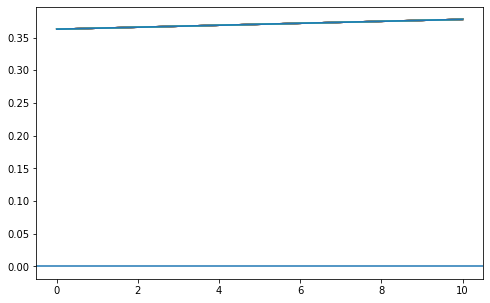

In [296]:
plt.plot(B1[:, -1, :])
plt.axhline(0)
plt.show()

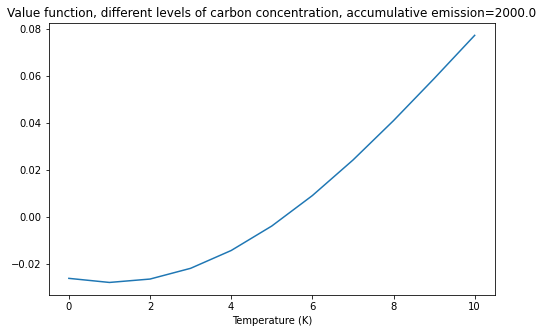

In [297]:
ii = -1
plt.plot(T_grid, v0[:, -1, ii])
plt.xlabel("Temperature (K)")
plt.title("Value function, different levels of carbon concentration, accumulative emission={}".format(F_grid[ii]))
plt.show()

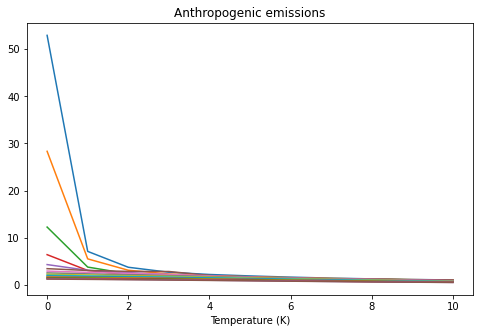

In [298]:
plt.plot(T_grid, Ca[:, :, 6])
plt.xlabel("Temperature (K)")
plt.title("Anthropogenic emissions")
plt.show()

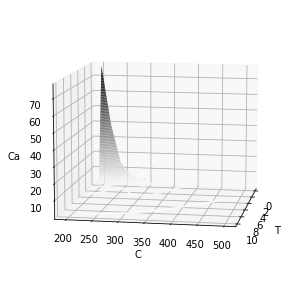

In [299]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(T_mat[:, :, 10], C_mat[:, :, 10], Ca[:, :, ii], 90, cmap='binary')
ax.set_xlabel('T')
ax.set_ylabel('C')
ax.set_zlabel('Ca')
ax.view_init(10, 10)

In [300]:
t_max = 600.
dt = 1/12
dt = 1  # , Gigaton per year
gridpoints = (T_grid, C_grid, F_grid)   
Ca_func = RegularGridInterpolator(gridpoints, Ca)

T_0 = To + min(T_grid)
C_0 = 275.5
F_0 = 0. #(870 - 580) / 2.13 # total cumulated, as of now, preindustrial with Fo

# T_0 = To + 1.1
# C_0 = 417
# F_0 = (870 - 580) / 2.13

def get_e(x):
    return Ca_func([x[0] - To, x[1], x[2]])

# Ocean albedo
def alphaocean_1d(T):
    if T < Talphaocean_low:
        return alphaocean_max
    elif T < Talphaocean_high:
        return alphaocean_max + (alphaocean_min - alphaocean_max) / (Talphaocean_high - Talphaocean_low) * (T - Talphaocean_low)
    else: # so T is higher
        return alphaocean_min

# Vegetation growth function
def veggrowth_1d(T):
    if T < Tlow:
        return 0
    if (T >= Tlow) and (T < Topt1):
        return acc / (Topt1 - Tlow) * (T - Tlow)
    if (T >= Topt1) and (T <= Topt2):
        return acc
    if (T > Topt2) and (T < Thigh):
        #return acc
        return acc / (Topt2 - Thigh) * (T - Thigh)
    if T > Thigh:
        #return acc
        return 0

def oceanatmphysflux_1d(T):
    return 1 / tauc * (coc0 * (np.exp(-bP * (T - T0))))

def fracseaice_1d(T):
    if T < Talphaocean_low:
        return 1
    elif T < Talphaocean_high:
        return 1 - 1 / (Talphaocean_high - Talphaocean_low) * (T - Talphaocean_low)
    else: # so T is higher
        return 0

def biopump_1d(Cc):
    if Cc < Cbio_low:
        return 1
    elif Cc < Cbio_high:
        return 1 - 1 / (Cbio_high - Cbio_low) * (Cc - Cbio_low)
    else: 
        return 0


def oceanbioflux_1d(T, F, sa):
     return 1/tauc * (coc0 * (np.exp(bB * biopump_1d(F) * (T - T0))))

def oceanatmcorrflux_1d(C):
    return 1 / tauc * (- cod * C)


def mu_T(x):
    Ri_t = 1 / cearth * (Q0 * (1 - p * alphaland - (1 - p) * alphaocean(x[0])))
    Ro_t = 1 / cearth * (kappa * (x[0] - Tkappa) -  B * np.log(x[1] / C0))
    return Ri_t - Ro_t

def mu_C(x):
    Ca_t = Ca_func([x[0] - To, x[1], x[2]])
    dC = Volcan
    dC += Ca_t * sa
    dC -= wa * x[1] * vegcover * veggrowth_1d(x[0])
    dC += oceanatmphysflux_1d(x[0]) * (1 - fracseaice_1d(x[0]))
    dC += oceanbioflux_1d(x[0], x[2], sa) * (1 - fracseaice_1d(x[0]))
    dC += oceanatmcorrflux_1d(x[1]) * (1 - fracseaice_1d(x[0]))
    return dC

def mu_Sa(x):
    return Ca_func([x[0] - To, x[1], x[2]])

years  = np.arange(0, t_max + dt, dt)
pers   = len(years)

hist      = np.zeros([pers, 3])
e_hist    = np.zeros([pers])


for tm in range(pers):
    if tm == 0:
        # initial points
        hist[0,:] = [T_0, C_0, F_0] # logL
        e_hist[0] = get_e(hist[0, :])

    else:
        # other periods
        e_hist[tm] = get_e(hist[tm-1,:])

        hist[tm,0] = max(hist[tm-1,0] + mu_T(hist[tm-1,:]) * dt, To + min(T_grid))
        hist[tm,1] = hist[tm-1,1] + mu_C(hist[tm-1,:]) * dt
        hist[tm,2] = hist[tm-1,2] + mu_Sa(hist[tm-1,:]) * dt


In [301]:
min(T_grid), hist

(1e-08,
 array([[ 282.87000001,  275.5       ,    0.        ],
        [ 282.87000001,  280.94778547,    5.91715148],
        [ 282.88132383,  285.55397927,   11.06965055],
        ...,
        [ 286.48728752,  251.07789319, 1284.36647236],
        [ 286.43550894,  251.02319756, 1285.99642805],
        [ 286.38351981,  251.01632599, 1287.63682796]]))

Text(0.5, 1.0, '$S_a$')

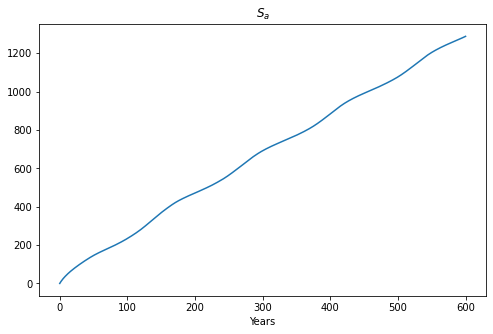

In [302]:
plt.plot(years[:], hist[:, 2])
plt.xlabel("Years")
plt.title("$S_a$")

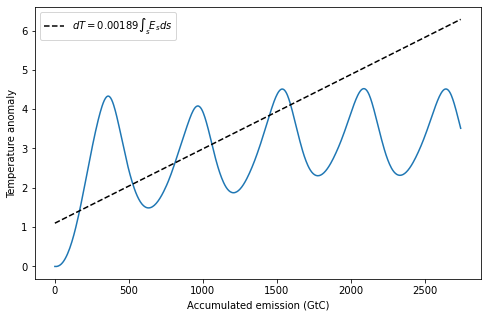

In [303]:
plt.plot(hist[:, 2] * 2.13, hist[:, 0] - To)
plt.plot(hist[:, 2] * 2.13, 1.1 +  (hist[:, 2] - hist[0, 2]) * 2.13 * 0.00189, 
         linestyle="dashed", color="black", label="$dT = 0.00189 \int_s E_s ds$")
plt.xlabel("Accumulated emission (GtC)")
plt.ylabel("Temperature anomaly")
plt.legend()
# plt.savefig("T_F_35.pdf")

In [304]:
e_hist

array([5.91715148, 5.91715148, 5.15249906, 4.85721789, 4.57925202,
       4.32509902, 4.09877277, 3.9105111 , 3.78619721, 3.66821294,
       3.55670572, 3.45173541, 3.35328572, 3.26127486, 3.17554976,
       3.09586627, 3.02200943, 2.96183592, 2.90521417, 2.85518653,
       2.80879033, 2.76539732, 2.72488552, 2.68712771, 2.65199325,
       2.61934963, 2.58906394, 2.56100416, 2.53488267, 2.50851104,
       2.4837786 , 2.46020092, 2.4374056 , 2.41579238, 2.39520666,
       2.37551028, 2.35658978, 2.34153219, 2.32462229, 2.30153339,
       2.27776217, 2.25320524, 2.22779152, 2.20148202, 2.17426953,
       2.14617828, 2.11726345, 2.08761069, 2.05733534, 2.02658165,
       1.98478887, 1.93342028, 1.89415339, 1.86462585, 1.83684978,
       1.81079312, 1.78641219, 1.76365306, 1.74245303, 1.72274205,
       1.70455994, 1.68853056, 1.67374485, 1.66011216, 1.64754143,
       1.63594234, 1.62522628, 1.61530732, 1.60610299, 1.59753503,
       1.58952997, 1.58201968, 1.59045942, 1.60340013, 1.61649

(-0.1, 13.07727508716027)

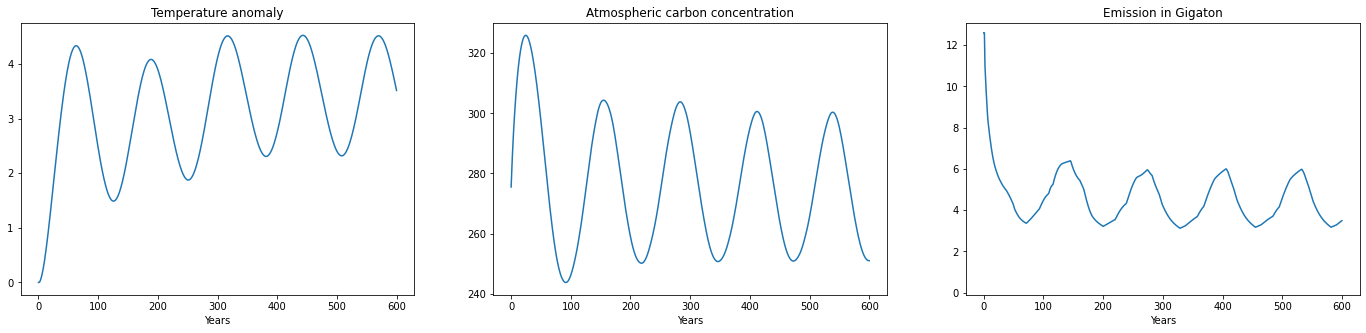

In [307]:
plt.subplots(1,3, figsize=(24,5))
plt.subplot(131)
plt.plot(years, hist[:, 0] - To)
plt.xlabel("Years")
plt.title("Temperature anomaly")
plt.subplot(132)
plt.plot(years, hist[:, 1])
plt.xlabel("Years")
plt.title("Atmospheric carbon concentration")
plt.subplot(133)
plt.plot(years, e_hist * 2.13)
plt.xlabel("Years")
plt.title("Emission in Gigaton")
plt.ylim(-0.1)
# plt.savefig(f"T_C_E_{cearth}_{tauc}.pdf")

In [308]:
res = {
    "v0": v0,
    "T": T_grid,
    "C": C_grid,
    "F": F_grid,
    "Ca": Ca,
}

pickle.dump(res, open(f"./data_{cearth}_{tauc}", "wb"))

In [133]:
Et = e_hist * 2.13

Text(0.5, 1.0, 'Emission in GtC')

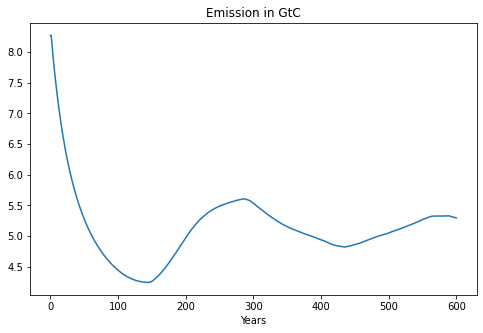

In [134]:
plt.plot(years, Et)
plt.xlabel("Years")
plt.title("Emission in GtC")

In [35]:
# df = pd.DataFrame({
#     'Years': years,
#     'Et(Gigaton)': Et,
#                   })

# df.to_csv("Et.csv", index=False)